In [1]:
import math
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import re
import seaborn
import time
import warnings

import nltk
#nltk.download()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jftgxfjxg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size="6">EDA</font>

First, the training data is examined to see what columns exist and what type of information they hold. Each column is then check for common bad values: empty, NaN, or null, of which none are found.

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/obbrown1/Unsupervised-Algorithms-in-Machine-Learning/main/BBC%20News%20Train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/obbrown1/Unsupervised-Algorithms-in-Machine-Learning/main/BBC%20News%20Test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [3]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
# Check for empty values
empty_columns = df_train.columns[df_train.isnull().all()]
print("Empty columns:", empty_columns)

# Check for null values
null_columns = df_train.columns[df_train.isnull().any()]
print("Null columns:", null_columns)

# Check for NaN values
nan_columns = df_train.columns[df_train.isna().any()]
print("NaN columns:", nan_columns)

# Check for missing values
missing_columns = df_train.columns[df_train.isnull().any() | df_train.isna().any()]
print("Missing value columns:", missing_columns)

Empty columns: Index([], dtype='object')
Null columns: Index([], dtype='object')
NaN columns: Index([], dtype='object')
Missing value columns: Index([], dtype='object')


A few calculated columns are added to further explore the data.

In [5]:
def count_words(text):
    words = text.split()
    return len(words)

def len_text(text):
    return len(text)
    
# Apply the count_words function to each row of the 'text' column
df_train['word count'] = df_train['Text'].apply(count_words)
df_train['len'] = df_train['Text'].apply(len_text)
df_train['avg_word_length'] = df_train['len'] / df_train['word count']
df_train

,ArticleId,Text,Category,word count,len,avg_word_length
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,1866,6.199336
1,154,german business confidence slides german busin...,business,325,2016,6.203077
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,3104,6.038911
3,1976,lifestyle governs mobile choice faster bett...,tech,634,3618,5.706625
4,917,enron bosses in $168m payout eighteen former e...,business,355,2190,6.169014
...,...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,223,1266,5.677130
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,558,3111,5.575269
1487,1590,weak dollar hits reuters revenues at media gro...,business,237,1370,5.780591
1488,1587,apple ipod family expands market apple has exp...,tech,560,3242,5.789286


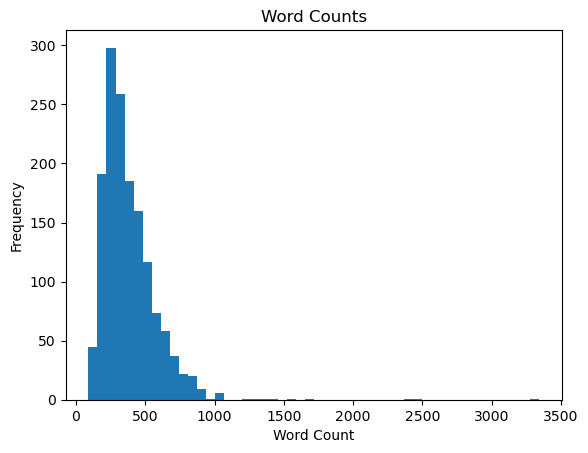

In [6]:
#Plot word counts
plt.hist(df_train['word count'], bins = 50)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Counts')
plt.show()

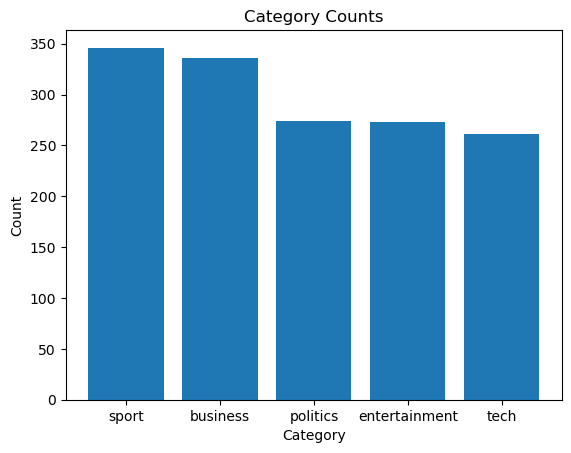

In [7]:
category_counts = df_train['Category'].value_counts()

#Plot category counts
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')
plt.show()

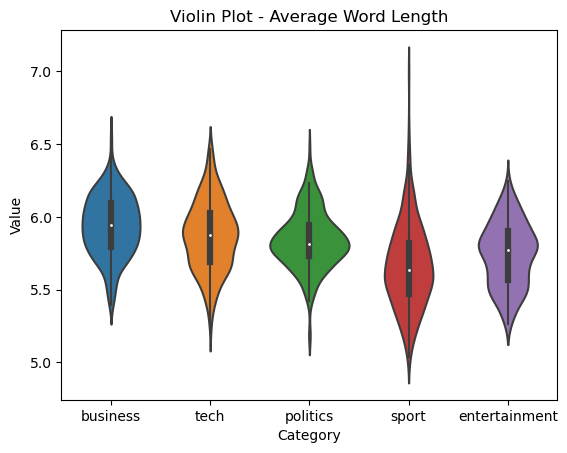

In [8]:
#Violin plot of word counts
seaborn.violinplot(x='Category', y='avg_word_length', data=df_train)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Violin Plot - Average Word Length')

# Show the plot
plt.show()

In [9]:
filtered_df = df_train[df_train['avg_word_length'] > 6]
sorted_df = filtered_df.sort_values(by='avg_word_length', ascending=False)
sorted_df

,ArticleId,Text,Category,word count,len,avg_word_length
657,2111,worcester v sale (fri) sixways friday 25 feb...,sport,116,811,6.991379
852,1320,hereford 1-1 doncaster hereford win 3-1 on pen...,sport,125,827,6.616000
115,461,monsanto fined $1.5m for bribery the us agroch...,business,321,2106,6.560748
769,984,india seeks to boost construction india has cl...,business,395,2575,6.518987
1201,1808,english clubs make euro history all four of en...,sport,182,1180,6.483516
...,...,...,...,...,...,...
284,727,merritt close to indoor 400m mark teenager las...,sport,243,1460,6.008230
1106,1950,huge rush for jet airways shares indian airlin...,business,215,1291,6.004651
1129,801,more women turn to net security older people a...,tech,615,3692,6.003252
711,500,argentina closes $102.6bn debt swap argentina ...,business,321,1927,6.003115


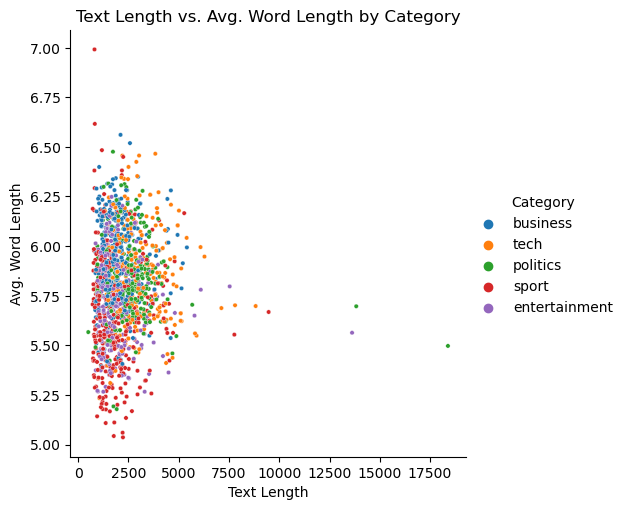

In [10]:
seaborn.relplot(data=df_train, x='len', y='avg_word_length', hue='Category', s=10)
plt.xlabel('Text Length')
plt.ylabel('Avg. Word Length')
plt.title('Text Length vs. Avg. Word Length by Category')
plt.show()

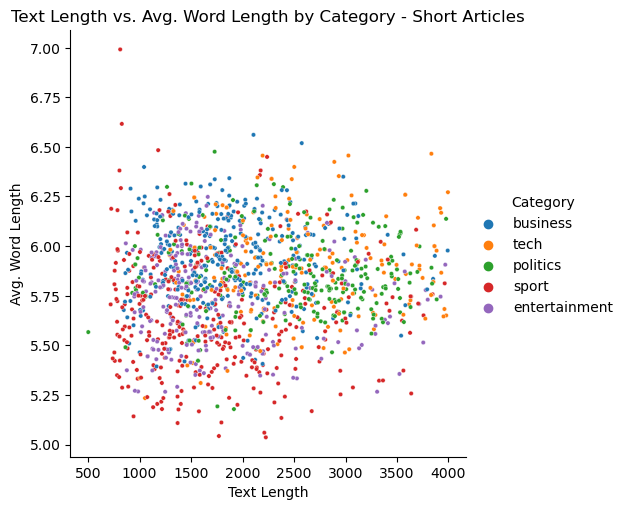

In [11]:
df_short = df_train[df_train['len'] < 4000]
seaborn.relplot(data=df_short, x='len', y='avg_word_length', hue='Category', s=10)
plt.xlabel('Text Length')
plt.ylabel('Avg. Word Length')
plt.title('Text Length vs. Avg. Word Length by Category - Short Articles')
plt.show()

<font size="6">Data Cleaning</font>

Below is an example of a single text field. The data cleaning function is then applied to the training data, which removes stop words, punctuation, and blank spaces. Stop word are extremely common words such as "a", "and", and "the", which do little to discriminate one piece of text from another. Removing them, along with punctuation and blank spaces, increases the signal-to-noise ratio of the text, speeds up algorithm runtimes, and makes workflows more portable across different datasets.

As shown below, applying the cleaning function significantly reduces the word count and text length, and slightly increases the average word length, as would be expected. It shifts average word counts up across all categories, and removes some many of the outliers on the low end of the average word length measure.

In [12]:
print(df_train['Text'][0][:500])
print('\nText length: ', df_train['len'][0])
print('Word count: ', df_train['word count'][0])
print('Average word length: ', df_train['avg_word_length'][0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspi

Text length:  1866
Word count:  301
Average word length:  6.1993355481727574


In [13]:
def clean_text(text):

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

df_train_c = df_train
df_train_c['Text'] = df_train_c['Text'].apply(clean_text)
df_test_c = df_train
df_test_c['Text'] = df_train_c['Text'].apply(clean_text)
df_train_c['word count'] = df_train_c['Text'].apply(count_words)
df_train_c['len'] = df_train_c['Text'].apply(len_text)
df_train_c['avg_word_length'] = df_train_c['len'] / df_train_c['word count']

In [14]:
print(df_train_c['Text'][0][:500])
print('\nText length: ', df_train_c['len'][0])
print('Word count: ', df_train_c['word count'][0])
print('Average word length: ', df_train_c['avg_word_length'][0])

worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant warnings led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide ex

Text length:  1388
Word count:  185
Average word length:  7.5027027027027025


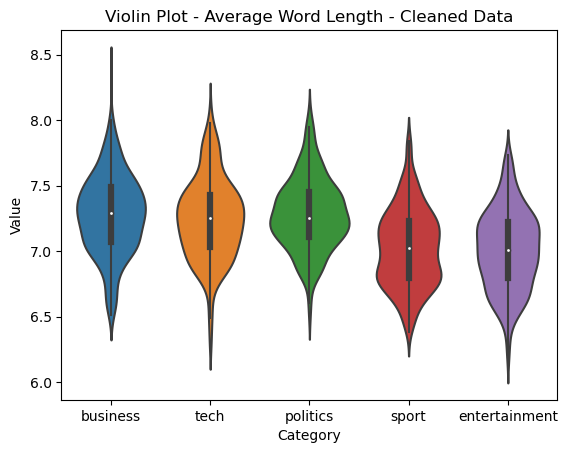

In [15]:
#Violin plot of word counts
seaborn.violinplot(x='Category', y='avg_word_length', data=df_train_c)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Violin Plot - Average Word Length - Cleaned Data')

# Show the plot
plt.show()

<font size="6">Analysis - Feature Extraction</font>

I will use term frequency-inverse document frequency (TF-IDF) to extract features from the text data and prepare it to be used as input for non-negative matrix factorization (NMF). At a high level, TF-IDF is an algorithm to assign weights to words within documents which themselves appear within a larger corpus of many such documents. It assigns a heavier weight to a word that appears more frequently in a document, and offets that weight based on how frequently it appears in the whole of the corpus. Therefore, words that are more unique to and characteristic of a given document will be weighted more heavily. 

Having explored the data, it is clear that removing stop words and extraneous characters like punctuation and white space has improved the data and better prepared it for analysis using TF-IDF and NMF. Removing stop words not only increases efficiency by condensing the corpus of text, it also increases the signal to noise ratio of the text by removing words that do little to differentiate documents from eachother and gives the TF-IDF algorithmm a better chance at capturing characteristic words.

Capturing characteristic words is crucial for NMF to effectively identify latent topics and extract meaningful features. Applying TF-IDF first ensures that NMF operates on a representation of the data that captures the relative importance of terms, enabling the discovery of underlying semantic structures and patterns in the text corpus. 

In [16]:
#Train data only
tvec = TfidfVectorizer()
train_vec = tvec.fit_transform(df_train_c['Text'])

nmf_model = NMF(n_components=5)
train_nmf = nmf_model.fit_transform(train_vec)

classifier = LogisticRegression()
classifier.fit(train_nmf, df_train_c['Category'])

pred_train = classifier.predict(train_nmf)

acc = accuracy_score(df_train_c['Category'], pred_train)
print('Training accuracy: ', acc)

Training accuracy:  0.8932885906040269


In [17]:
#Train and test data
#tvec = TfidfVectorizer()
text_data = pd.concat([df_test_c['Text'], df_train_c['Text']], ignore_index=True)
category_data = pd.concat([df_test_c['Category'], df_train_c['Category']], ignore_index=True)
train_vec = tvec.fit_transform(text_data)

#nmf_model = NMF(n_components=5)
train_nmf = nmf_model.fit_transform(train_vec)

classifier = LogisticRegression()
classifier.fit(train_nmf, category_data)

pred_train = classifier.predict(train_nmf)

acc = accuracy_score(category_data, pred_train)
print('Training accuracy: ', acc)

Training accuracy:  0.9053691275167786


<font size="6">Matrix Factorization</font>

*When you train the unsupervised model for matrix factorization, should you include texts (word features) from te test dataset or not as the input matrix? Why or why not?*

As shown above, using the entirety of the text corpus does improve the training accuracy, likely because it allows the TF-IDF algorithm to create a larger set of vocabulary that can be used to distinguish documents. With other machine learning algorithms, using all of the data to train the model can be problematic, as it may lead to overfitting. In this case, however, that is not a concern, as the target labels are not included in the text data and therefore no overfitting can occur.

In [18]:
nmf_model = NMF(n_components=5)
train_nmf = nmf_model.fit_transform(train_vec)

classifier = LogisticRegression()
classifier.fit(train_nmf, category_data)

pred_train = classifier.predict(train_nmf)

acc = accuracy_score(category_data, pred_train)
print('Training accuracy: ', acc)

Training accuracy:  0.9053691275167786


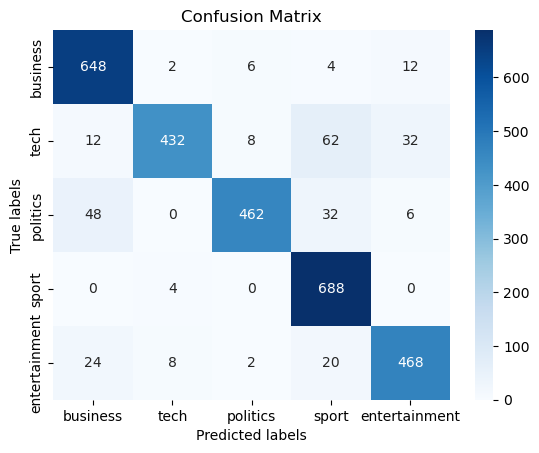

In [19]:
cm = confusion_matrix(category_data, pred_train)

# Create a heatmap of the confusion matrix
categories = df_train_c['Category'].unique()
seaborn.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels = categories, yticklabels = categories)

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.xticks(ticks=1, labels = df_train_c['Category'].unique())

# Show the plot
plt.show()

<font size="6">Hyperparameter Tuning</font>

In [20]:
def hyperparameter_tuning_NMF(df):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('nmf', NMF()),
        ('classifier', LogisticRegression())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1, 2],
        'nmf__n_components': [5],
        'nmf__solver': ['mu'],
        'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
        'nmf__l1_ratio': [0, 0.5, 1]
    }
    
    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(df['Text'], df['Category'])
    
    return (grid_search.best_estimator_, grid_search.best_params_)

In [21]:
st = time.time()
(best_model, best_params) = hyperparameter_tuning_NMF(df_train_c)
best_params = {key: [value] for key, value in best_params.items()}
pd.DataFrame(best_params)
nmf_pst = time.time() - st
print('Parameter search time: ', nmf_pst)

Parameter search time:  372.1904239654541


In [22]:
st = time.time()
pred = best_model.predict(df_test_c['Text'])
nmf_acc = accuracy_score(df_test_c['Category'], pred)
print('NMF accuracy: ', nmf_acc)
nmf_pt = time.time() -st
print('Prediction time: ', nmf_pt)

NMF accuracy:  0.963758389261745
Prediction time:  2.8959975242614746


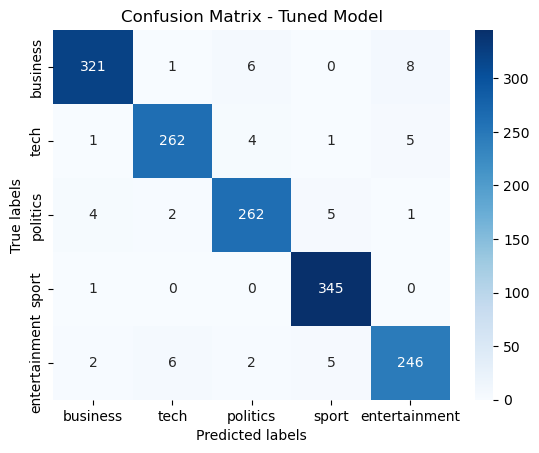

In [23]:
cm2 = confusion_matrix(df_train_c['Category'], pred)

seaborn.heatmap(cm2, annot=True, cmap='Blues', fmt='d', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Tuned Model')
plt.show()

<font size="6">Supervised Learning - Logistic Regression</font>

In [25]:
warnings.filterwarnings('ignore')
st = time.time()

LR_train_vec = tvec.fit_transform(df_train_c['Text'])

logreg = LogisticRegression()
param_grid = {'C': [0.1, 1, 10],
             'solver': ['newton-cg', 'lbfgs', 'liblinear'],
             'penalty':['l1', 'l2']
             }

st = time.time()
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(LR_train_vec, df_train_c['Category'])
best_params_lr = grid_search.best_params_

lr_pst = time.time() - st
print('Parameter search time: ', lr_pst)
params_lr = {key: [value] for key, value in best_params_lr.items()}
pd.DataFrame(params_lr)

warnings.filterwarnings('default')

Parameter search time:  73.70681476593018


In [26]:
logreg_best = LogisticRegression(**best_params_lr)
logreg_best.fit(LR_train_vec, df_train_c['Category'])

LR_test_vec = tvec.fit_transform(df_test_c['Text'])
st = time.time()
y_pred = logreg_best.predict(LR_test_vec)
lr_pt = time.time() - st
print('Predict time: ', lr_pt)

lr_acc = accuracy_score(df_test_c['Category'], y_pred)
print("Accuracy:", lr_acc)

Predict time:  0.010003089904785156
Accuracy: 1.0


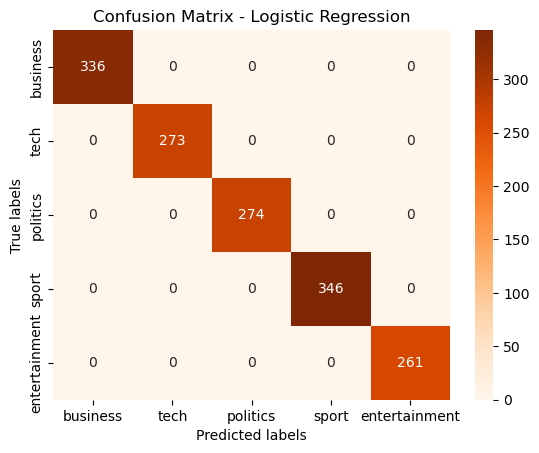

In [27]:
cm_lr = confusion_matrix(df_train_c['Category'], y_pred)
seaborn.heatmap(cm_lr, annot=True, cmap='Oranges', fmt='d', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

<font size="4">Supervised Learning - Logistic Regression - Random Subset</font>

Below, we will see how logistic regression performs on a random subset of the combined train and test data.

In [28]:
df_all = pd.concat([df_train_c, df_test_c], ignore_index = 1)
df_rand = df_all.sample(int(len(df_all)*0.5))
LR_random_vec = tvec.fit_transform(df_rand['Text'])

logreg_rand = LogisticRegression(**best_params_lr)
logreg_rand.fit(LR_random_vec, df_rand['Category'])

st = time.time()
y_pred_rand = logreg_rand.predict(LR_random_vec)
lr_rand_pt = time.time() - st
print('Predict time: ', lr_rand_pt)

lr_rand_acc = accuracy_score(df_rand['Category'], y_pred_rand)
print("Accuracy:", lr_rand_acc)


Predict time:  0.006997823715209961
Accuracy: 1.0


<font size="6">Supervised Learning - Random Forest</font>

In [29]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [3, 5, 7]
}

rf_train_vec = tvec.fit_transform(df_train_c['Text'])
rf_test_vec = tvec.fit_transform(df_test_c['Text'])

st = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(rf_train_vec, df_train_c['Category'])
rf_pst = time.time() - st
print('Parameter search time: ', rf_pst)

best_params_rf = grid_search.best_params_

Parameter search time:  115.38959336280823


In [30]:
rf_params = {key: [value] for key, value in best_params_rf.items()}
pd.DataFrame(rf_params)

,max_depth,n_estimators
0,7,200


In [31]:
# Train the model with the best hyperparameters
rf_best = RandomForestClassifier(**best_params_rf)
rf_best.fit(rf_train_vec, df_train_c['Category'])

st = time.time()
y_pred_rf = rf_best.predict(rf_test_vec)
rf_pt = time.time() - st

rf_acc = accuracy_score(df_test_c['Category'], y_pred_rf)
print("Accuracy:", rf_acc)
print('Predict time: ', rf_pt)

Accuracy: 0.9651006711409396
Predict time:  0.5177068710327148


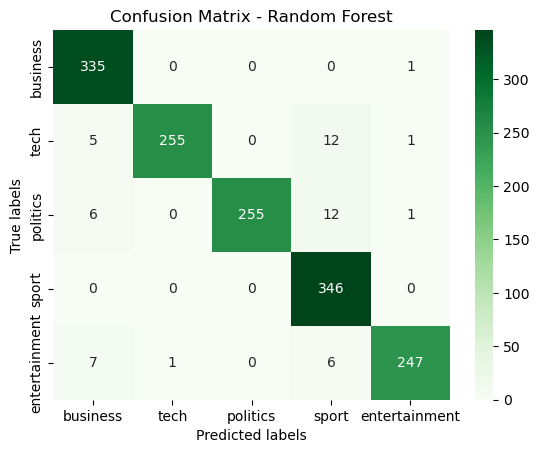

In [32]:
cm_rf = confusion_matrix(df_train_c['Category'], y_pred_rf)
seaborn.heatmap(cm_rf, annot=True, cmap='Greens', fmt='d', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

<font size="4">Supervised Learning - Random Forest - Random Subset</font>

Below, we will see how random forest performs on a random subset of the combined train and test data.

In [33]:
rf_rand = RandomForestClassifier(**best_params_rf)
rf_rand_vec = tvec.fit_transform(df_rand['Text'])
rf_rand.fit(rf_rand_vec, df_rand['Category'])


st = time.time()
y_pred_rf = rf_rand.predict(rf_rand_vec)
rf_pt = time.time() - st

rf_acc = accuracy_score(df_rand['Category'], y_pred_rf)
print("Accuracy:", rf_acc)
print('Predict time: ', rf_pt)

Accuracy: 0.9778523489932885
Predict time:  0.9708750247955322


<font size="6">Supervised vs. Unsupervised Learning</font>

The table below shows that, while all models achieve good accuracy, the supervised methods achieve the best accuracy and in less time than the unsupervised NMF model. Logistic regression, in particular, is the most accurate method of the three, and also the fastest across both time dimensions. One advantage of the NMF model is that it is not prone to overfitting, while the supervised models are. This could become a more significant factor if the dataset were to increase in size or the analysis were to increase in complexity.

In [34]:
comparison = pd.DataFrame({
    'Model':['NMF', 'Logistic Regression', 'Random Forest'],
    'Accuracy':[nmf_acc, lr_acc, rf_acc],
    'Tuning Time':[nmf_pst, lr_pst, rf_pst],
    'Prediction Time':[nmf_pt, lr_pt, rf_pt]
})

comparison

,Model,Accuracy,Tuning Time,Prediction Time
0,NMF,0.963758,372.190424,2.895998
1,Logistic Regression,1.000000,73.706815,0.010003
2,Random Forest,0.977852,115.389593,0.970875


<font size="6">References</font>


https://en.wikipedia.org/wiki/Tf%E2%80%93idf

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://towardsdatascience.com/mastering-random-forests-a-comprehensive-guide-51307c129cb1



https://www.kaggle.com/code/robinlutter/bbc-news-classification-nmf-vs-supervised